# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I' = \mathbf{G}(I,M) \, u,\quad u(M) \in U, $$

$$ \delta I(0) = 0, \quad \delta I(2\pi) \parallel \mathbf{d}, $$

$$ \left( \delta I (2\pi) \, | \, \mathbf{d} \right) \longrightarrow \max. $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{d}$. 

[Thumbnail](solarsail.jpg)

## Initializations

In [1]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from scipy.linalg import null_space
from gve import *
from os import system

# Definition of optical parameters 
rho     = 0.6         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 1.         # 0 for triangular cone, 1 for real drop 
mu      = 1.
sDir    = np.array([0., 0., -1.])

# Initial guess of pdeltaI taken from Matlab Convex Programming
pdeltaI        = np.array([-0.15486778, -0.23740693, -0.11720524, -0.24128161,  1.])
M1_guess       = 0.99543827
M2_guess       = 5.23631576
deltaI1_guess  = np.array([-1.08419292,  0.20700834,  0.85424687, -0.033123,    0.03894396])
deltaI2_guess  = np.array([-1.08419292,  0.20700834,  0.85424687, -0.033123,    0.03894396])
z              = np.hstack((pdeltaI, M1_guess, M2_guess, deltaI1_guess, deltaI2_guess)) 

def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y


# Initial state

I           = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.6])                         # Initial state
d           = np.array([ 0.,  0.,  0.,  0.,  1.])                                               # Direction of the displacement
deltaI0     = np.array([0., 0., 0., 0., 0])                                                     # delta I (0)
M0          = 0
Mf          = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [2]:
#!pygmentize hfun.f90			

## Hamiltonian

In [3]:
def hamiltonian_implicit(compile=False, display=False):
    
    if display:
        out = ''
    else:
        out = ' > /dev/null 2>&1'
    
    if not compile:
        try:
            from hfunimplicit         import hfunimplicit        as hfun_u
            from hfunimplicit_di      import hfunimplicit_di     as dhfun_u
            from hfunimplicit_di_di   import hfunimplicit_di_di  as d2hfun_u
            from hfunalpha_da         import hfunalpha_da        as dhfunalpha 
            from hfunalpha_da_da      import hfunalpha_da_da     as d2hfunalpha
            import hfunalpha
            
        except ModuleNotFoundError:
            compile = True
        
    if compile:
        # Compiling hmin
        os.system('python -m numpy.f2py -c hfunimplicit.f90 hfunalpha.f90 hfunalpha_da_da.f90 hfuncone_dc.f90 hfunalpha_da.f90 -m hfunimplicit ' + out)
        os.system('python -m numpy.f2py -c hfunimplicit_di.f90     -m hfunimplicit_di    ' + out)
        os.system('python -m numpy.f2py -c hfunimplicit_di_di.f90 -m hfunimplicit_di_di ' + out)
        os.system('python -m numpy.f2py -c hfunalpha_da.f90 -m hfunalpha_da ' + out)
        os.system('python -m numpy.f2py -c hfunalpha_da_da.f90 hfunalpha_da.f90 -m hfunalpha_da_da ' + out)
        os.system('python -m numpy.f2py -c hfunalpha.f90 -m hfunalpha ' + out)
        
        from hfunimplicit             import hfunimplicit        as hfun_u
        from hfunimplicit_di          import hfunimplicit_di     as dhfun_u
        from hfunimplicit_di_di       import hfunimplicit_di_di  as d2hfun_u
        from hfunalpha_da             import hfunalpha_da        as dhfunalpha 
        from hfunalpha_da_da      import hfunalpha_da_da     as d2hfunalpha
        import hfunalpha
        
    ufun        = lambda M, deltaI, pdeltaI, alpha, cont : hfunalpha.control(M, deltaI, pdeltaI, alpha, pars, cont)
    pmpcone     = lambda pIG, sDir, fcone                                              : hfunalpha.pmpcone(pIG, sDir, fcone)
    gveeci      = lambda M, I, mu                                                      : hfunalpha.gveeci(M, I, mu)

    hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
    ufun        = tools.vectorize(vvars=(1,2,3,4))(ufun)
    Hu          = ocp.Hamiltonian(hfun_u)
    
    return Hu, dhfunalpha, d2hfunalpha, ufun, gveeci, pmpcone


In [4]:
def dhfun_0(M, dM, deltaI, ddeltaI, pdeltaI, dpdeltaI, pars, cont, dcont):
    h   = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, deltaI, ddeltaI, d2deltaI, pdeltaI, dpdeltaI, d2pdeltaI, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, deltaI, pdeltaI, pars, cont):
    h   = 0.0
    return h

In [5]:
hfun_0           = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
[Hu, dhfunalpha, d2hfunalpha, ufun, gveeci, pmpcone] = hamiltonian_implicit(compile=True, display=False)
H0               = ocp.Hamiltonian(hfun_0)
fu               = ocp.Flow(Hu)
f0               = ocp.Flow(H0)


## Auxiliary function

In [6]:
def calculpIG(M, I, pdeltaI) :
    [fx, fy, fz] = gveeci(M, I, mu)
    pIG = np.array([0.0, 0.0, 0.0])
    pIG[0] = np.dot(fx[0:5],pdeltaI)
    pIG[1] = np.dot(fy[0:5],pdeltaI)
    pIG[2] = np.dot(fz[0:5],pdeltaI)
    return pIG

## Initials guess for alpha

In [7]:
ddeltaI = np.zeros(5)
dpdeltaI = np.zeros(5)

def alphG0(alpha) : 
    return dhfunalpha(M0, 0, deltaI0, ddeltaI, pdeltaI, dpdeltaI, alpha, 1.0, pars, cont)[1]

print("For alpha0")

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
sol0 = nle.solve(alphG0, 1.0 , options=nleopt); 

print("Second derivative : ", d2hfunalpha(M0, 0, deltaI0, ddeltaI, pdeltaI, dpdeltaI, sol0.x, 1.0, 1.0, pars, cont)[2])

def alphG2(alpha) : 
    return dhfunalpha(M2_guess, 0, deltaI2_guess, ddeltaI, pdeltaI, dpdeltaI, alpha, 1.0, pars, cont)[1]

print("For alpha2")

nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
sol2 = nle.solve(alphG2, 1.0 , options=nleopt); 

print("Second derivative : ", d2hfunalpha(M2_guess, 0, deltaI2_guess, ddeltaI, pdeltaI, dpdeltaI, sol2.x, 1.0, 1.0, pars, cont)[2])


For alpha0

     Calls  |f(x)|                 |x|
 
         1  3.199967254378779e-01  1.000000000000000e+00
         2  6.499449762642839e-01  1.251974129474563e-01
         3  4.898298142120118e-02  7.113909395068396e-01
         4  2.582076534228943e-02  6.592277833561431e-01
         5  5.030916760574572e-04  6.772334671989437e-01
         6  4.494193982892969e-06  6.768893493268279e-01
         7  8.401102175037423e-10  6.768862475613239e-01
         8  1.387778780781446e-15  6.768862481410358e-01

 Results of the nle solver method:

 xsol    =  0.6768862481410358
 f(xsol) =  -1.3877787807814457e-15
 nfev    =  8
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Second derivative :  -1.4491880774728496
For alpha2

     Calls  |f(x)|                 |x|
 
         1  1.355363465287657e-02  1.000000000000000e+00
         2  4.867474636202074e-04  9.848997609744568e-01
         3  1.6096048315650

In [8]:
alpha0_guess   = sol0.x
alpha2_guess   =sol2.x

z = np.hstack((z, alpha0_guess, alpha2_guess))

## Shooting method 

In [9]:
#Initial condition 

deltaI0   = np.zeros(5)
M0        = 0.
Mf        = 2. * np.pi 

In [10]:
#@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont):
    #pdeltaI is constant
    pdeltaI0   = z[0 : 5]
    pdeltaI1   = pdeltaI0
    pdeltaI2   = pdeltaI1
    pdeltaIf   = pdeltaI2
    
    M1        = z[5]
    M2        = z[6]
    deltaI1   = z[7 : 12]
    deltaI2   = z[12 : 17]
    alpha0    = z[17]
    alpha2    = z[18]
    
    q0        = np.hstack((deltaI0, alpha0))
    q2        = np.hstack((deltaI2, alpha2))
    
    p0 = np.hstack((pdeltaI0, 0.0))
    p2 = np.hstack((pdeltaI2, 0.0))
    
    ddeltaI = np.zeros(5)
    dpdeltaI = np.zeros(5)

    #---------------------------------------------------------------------
    
    #Numerical integration
    
    #---------------------------------------------------------------------
    
    q1sol, p1sol  = fu(M0, q0, p0, M1, pars, cont)
    deltaI1sol = q1sol[0:5]
    
    deltaI2sol, _ = f0(M1, deltaI1, pdeltaI1, M2, pars, cont)
                         
    qfsol, _ = fu(M2, q2, p2, Mf, pars, cont)
    deltaIfsol = qfsol[0:5]
    
    #---------------------------------------------------------------------
    
    #Definition of s
    
    #---------------------------------------------------------------------
    
    s           = np.zeros(19)
    s[0]        = pdeltaIf[0] * d[0] + pdeltaIf[1] * d[1] + pdeltaIf[2] * d[2] + pdeltaIf[3] * d[3] + pdeltaIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]    = np.dot(d_orth, deltaIfsol)
    
    s[5]        = Hu(M1, q1sol, p1sol, pars, cont)
    s[6]        = Hu(M2, q2, p2, pars, cont)
    
    s[7 : 12]   = deltaI1 - deltaI1sol 
    s[12 : 17]  = deltaI2 - deltaI2sol
    
    s[17] = dhfunalpha(M0, 0, deltaI0, ddeltaI, pdeltaI0, dpdeltaI, alpha0, 1.0, pars, cont)[1]
    s[18] = dhfunalpha(M2, 0, deltaI2, ddeltaI, pdeltaI2, dpdeltaI, alpha2, 1.0, pars, cont)[1]
                          
    return s

In [11]:
def control(M, q, p, cont):
    sol  = np.array([0., 0., 0.])

    for ii in range(len(M)):
            if Hu(M[ii], q[ii], p[ii], pars, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M[ii], q[ii][0:5], p[ii][0:5], q[ii][5], cont))) 
    sol = np.delete(sol, 0, 0)
    return sol

## Solve

In [12]:
foo = lambda z, cont: shoot(z, pars, d, d_orth, cont)

In [13]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 

et = time.time(); sol = nle.solve(foo, z, options=nleopt, args=cont); 

et = time.time() - et
print('Elapsed time:', et)
z_sol = sol.x; 

print('z_sol =', z_sol)
print('foo =', foo(z_sol, cont))


     Calls  |f(x)|                 |x|
 
         1  1.571364574085542e-08  5.907009176220724e+00
         2  6.791295904495333e-15  5.907009179418899e+00

 Results of the nle solver method:

 xsol    =  [-0.15486778 -0.23740693 -0.11720524 -0.24128161  1.          0.99543827
  5.23631576 -1.08419292  0.20700834  0.85424687 -0.033123    0.03894396
 -1.08419292  0.20700834  0.85424687 -0.033123    0.03894396  0.67688625
  0.98540647]
 f(xsol) =  [ 0.00000000e+00 -6.66784336e-16 -4.58682571e-15 -1.97563320e-15
 -4.51873781e-15  1.70290714e-16  5.55111512e-17 -2.22044605e-16
 -2.22044605e-16 -3.33066907e-16  2.42861287e-16 -5.55111512e-17
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00]
 nfev    =  2
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.

Elapsed time: 4.577378749847412
z_sol = [-0.15486778 -0.23740693 -0.11720524 -0.24128161

## Plot function

In [14]:
def plotSolutionBSB(p0, alpha0, alpha2, M1, M2, Mf, sDir, cont, nOrb):
    
    #Initializations
    #--------------------------------------------
    
    N       = 500
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    alpha   = np.array([])
    dh      = np.array([])
    d2h     = np.array([])
    palpha  = np.array([])
    coneang = np.array([])
    
    q       = []
    p       = []
    
    deltaI   = np.array([0., 0., 0., 0., 0]) 
    deltaI0  = np.array([0., 0., 0., 0., 0])
    ddeltaI  = np.array([0., 0., 0., 0., 0])
    dpdeltaI = np.array([0., 0., 0., 0., 0])
    
    M0      = 0
    M0_2_M1 = np.linspace(M0, M1, N+1)
    M1_2_M2 = np.linspace(M1, M2, N+1)
    M2_2_Mf = np.linspace(M2, Mf, N+1)
    u_vect  = np.array([0., 0., 0.])
    q0      = np.hstack((deltaI0, alpha0))
    
    #--------------------------------------------

        
    for ii in range(nOrb):
        Mspan1  = list((ii)*2*np.pi*np.ones(N+1)+M0_2_M1)
        Mspan2  = list((ii)*2*np.pi*np.ones(N+1)+M1_2_M2)
        Mspanf  = list((ii)*2*np.pi*np.ones(N+1)+M2_2_Mf)
        
        #Numerical integration
        #-------------------------------------------------------------------------------------------
        
        q1sol, p1sol = fu(M0, q0, p0, Mspan1, pars, cont)  
        deltaI2sol, pdeltaI2sol = f0(Mspan1[-1], q1sol[-1][0:5], p1sol[-1][0:5], Mspan2, pars, cont)  
        
        q2           = np.hstack((deltaI2sol[-1], alpha2))
        p2           = p0
        
        qfsol, pfsol = fu(Mspan2[-1], q2, p2, Mspanf, pars, cont) 
        
        #-------------------------------------------------------------------------------------------
        
        M_vect       = np.hstack((M_vect, Mspan1, Mspan2, Mspanf))  
        
        for kk in range(N+1):
            val           = q1sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            alpha         = np.hstack((alpha, rad2deg(val[5])))
            
            #Calcul of the cone angle
            #------------------------------------------------------------------------------
            
            cAlpha        = np.cos(val[5])
            sAlpha        = np.sin(val[5])

            fs            = b[0] * cAlpha + (b[1] * cAlpha**2 + b[2] * cAlpha) * cAlpha
            fperp         = (b[1] * cAlpha**2 + b[2] * cAlpha) * sAlpha
            
            coneang       = np.hstack((coneang,rad2deg(np.arctan2(fperp, fs))))
            
            #------------------------------------------------------------------------------

            palpha        = np.hstack((palpha, p1sol[kk][5]))
            dh            = np.hstack((dh, dhfunalpha(Mspan1[kk], 0, q1sol[kk][0:5], ddeltaI, p1sol[kk][0:5], dpdeltaI, q1sol[kk][5], 1.0, pars, cont)[1]))
            d2h           = np.hstack((d2h, d2hfunalpha(Mspan1[kk], 0, q1sol[kk][0:5], ddeltaI, p1sol[kk][0:5], dpdeltaI, q1sol[kk][5], 1.0, 1.0, pars, cont)[2]))           
                        
            q.append(q1sol[kk])
            p.append(p1sol[kk])
            
            
        for kk in range(N+1):         
            val           = deltaI2sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            coneang       = np.hstack((coneang,0.0))
            palpha        = np.hstack((palpha, 0))
            dh            = np.hstack((dh, 0))
            d2h           = np.hstack((d2h, 0))
            
            p.append(np.hstack((deltaI2sol[kk], alpha2)))
            q.append(np.hstack((pdeltaI2sol[kk], 0.0)))
            

        for kk in range(N+1):
            val           = qfsol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))           
            alpha         = np.hstack((alpha, rad2deg(val[5])))
            
            #Calcul of the cone angle
            #--------------------------------------------------
            
            cAlpha          = np.cos(val[5])
            sAlpha          = np.sin(val[5])

            fs              = b[0] * cAlpha + (b[1] * cAlpha**2 + b[2] * cAlpha) * cAlpha
            fperp           = (b[1] * cAlpha**2 + b[2] * cAlpha) * sAlpha
            
            coneang = np.hstack((coneang,rad2deg(np.arctan2(fperp, fs))))
            
            #--------------------------------------------------
            
            palpha        = np.hstack((palpha, pfsol[kk][5]))
            dh            = np.hstack((dh, dhfunalpha(Mspanf[kk], 0, qfsol[kk][0:5], ddeltaI, pfsol[kk][0:5], dpdeltaI, qfsol[kk][5], 1.0, pars, cont)[1]))
            d2h           = np.hstack((d2h, d2hfunalpha(Mspanf[kk], 0, qfsol[kk][0:5], ddeltaI, pfsol[kk][0:5], dpdeltaI, qfsol[kk][5], 1.0, 1.0, pars, cont)[2]))
            
            q.append(qfsol[kk])
            p.append(pfsol[kk])
            
        q0            = qfsol[-1]
        M0            = Mspanf[-1]
    
    #Calcul of the clock angle
    #---------------------------------------------------

    u_vect = control(M_vect, q, p, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]
    
    norm   = np.linalg.norm(u_vect,axis=1)
    ang2   = np.arctan2(u_2 / norm , u_1 / norm)
    where_are_NaNs = np.isnan(ang2)
    ang2[where_are_NaNs] = 0
    ang2   = rad2deg(ang2)
    
    #---------------------------------------------------

    #plots
    #-------------------------------------------------------------------------------------------------
    
    M_vect = M_vect / 2 / np.pi * 360
    fig    = plt.figure(); plt.tight_layout()
    ax1    = fig.add_subplot(521); 
    ax1.plot(M_vect, g1); 
    ax2    = fig.add_subplot(522); 
    ax2.plot(M_vect, g2); 
    ax3    = fig.add_subplot(523); 
    ax3.plot(M_vect, g3); 
    ax4    = fig.add_subplot(524); 
    ax4.plot(M_vect, a); 
    ax5    = fig.add_subplot(525); 
    ax5.plot(M_vect, e);
    ax6  = fig.add_subplot(526); 
    ax6.plot(M_vect, coneang, label="Cone angle");  
    ax6.plot(M_vect, ang2, label='clock angle');
    ax7    = fig.add_subplot(527); 
    ax7.plot(M_vect, dh); 
    ax8    = fig.add_subplot(528); 
    ax8.plot(M_vect, d2h); 
    ax9    = fig.add_subplot(529); 
    ax9.plot(M_vect, palpha);  
    
    label_name = 'Satellite longitude [deg]'
    
    ax1.set_xlabel(label_name); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel(label_name); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel(label_name); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel(label_name); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel(label_name); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    ax6.set_xlabel(label_name); ax6.set_ylabel('alpha');  
    ax6.legend()
    ax7.set_xlabel(label_name); ax7.set_ylabel('dh');
    ax8.set_xlabel(label_name); ax8.set_ylabel('d2h');
    ax9.set_xlabel(label_name); ax9.set_ylabel('palpha');                   ax9.axhline(0, color='k')
    plt.savefig('figures/plot.png')
    
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)



## Plots

In [15]:
pdeltaI0    = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
deltaI1    = z_sol[7 : 12]
deltaI2    = z_sol[12 : 17]
alpha0     = z_sol[17]
alpha2     = z_sol[18]

q2  = np.hstack((deltaI2, alpha2))
p0 = np.hstack((pdeltaI0, 0))
p2 = p0

qf, pf = fu(M2, q2, p2, Mf, pars, cont)
print(qf, pf)

[ 4.51873781e-15 -6.66784336e-16 -4.58682571e-15 -1.97563320e-15
  1.24976168e-01  6.76886252e-01] [-1.54867781e-01 -2.37406925e-01 -1.17205242e-01 -2.41281610e-01
  1.00000000e+00 -3.20315935e-11]


### One orbit

#### Trajectory

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


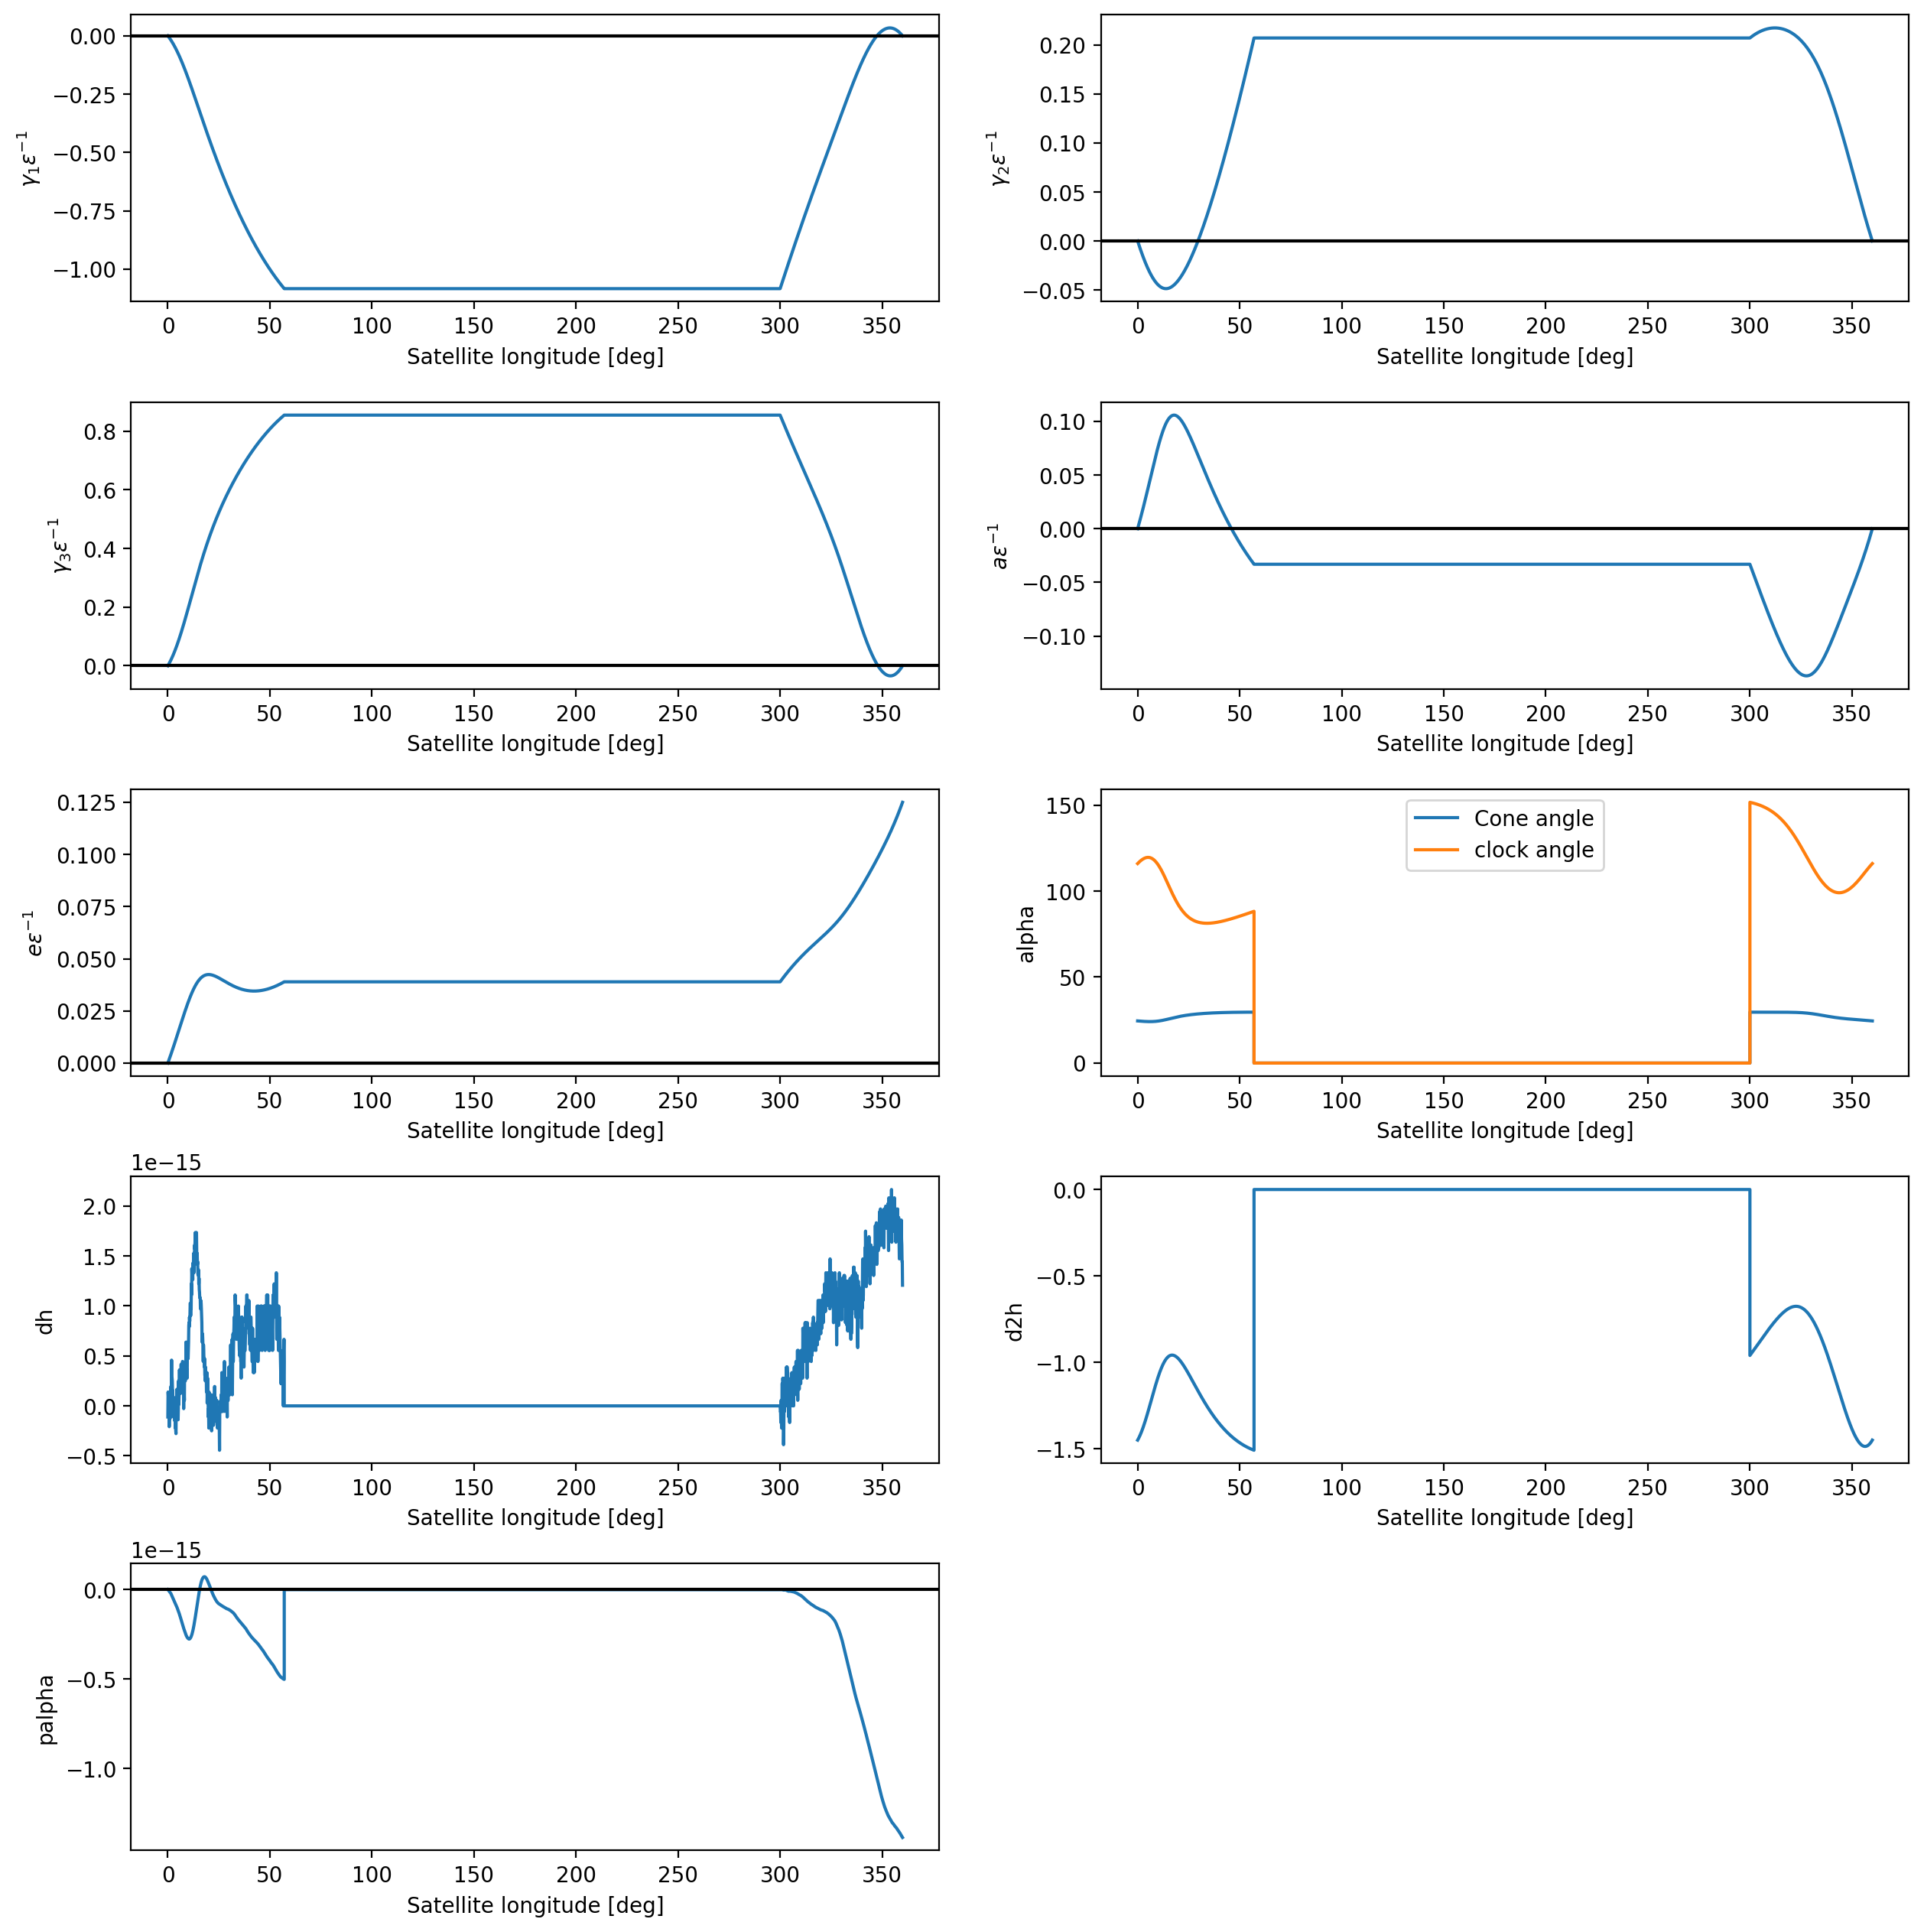

In [16]:
plotSolutionBSB(p0, alpha0, alpha2, M1, M2, Mf, sDir, cont, 1)

### Multiple orbits

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


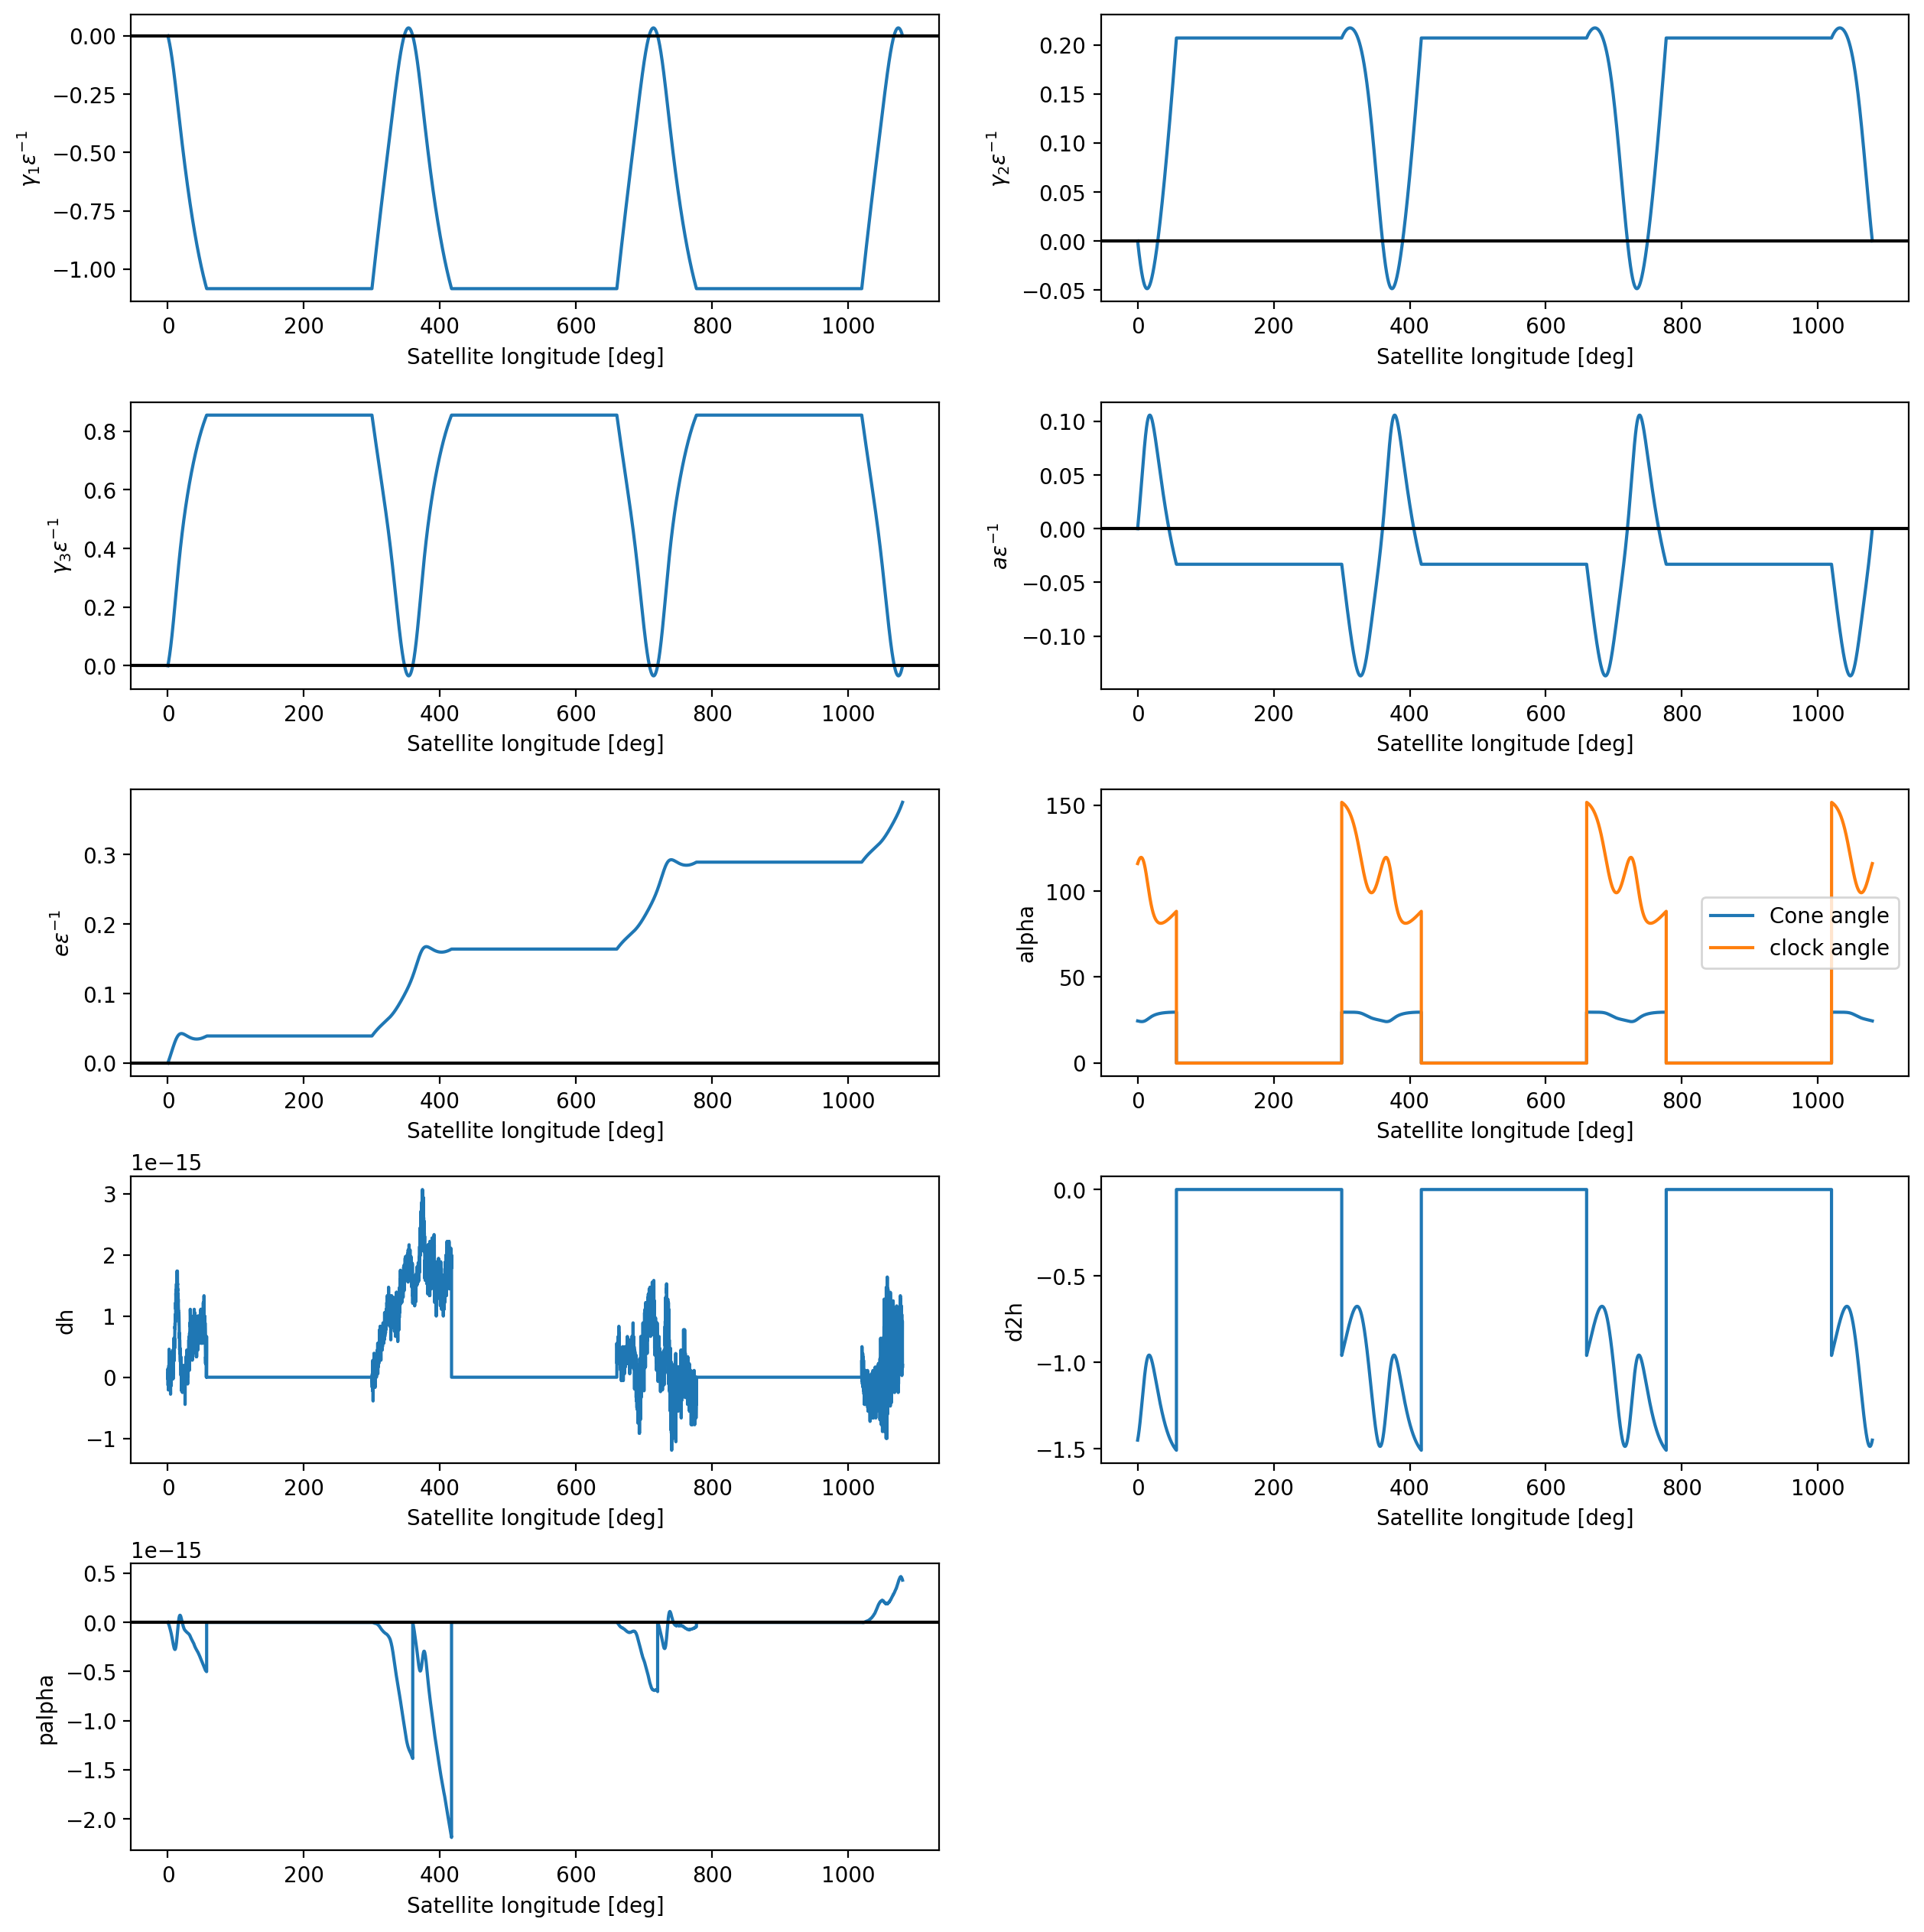

In [17]:
plotSolutionBSB(p0, alpha0, alpha2, M1, M2, Mf, sDir, cont, 3)